# Random Forest Model

In [ ]:
import pandas as pd
import numpy as np
import nfl_data_py as nfl
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Filter out the specific warnings we're getting
warnings.filterwarnings('ignore', message='invalid value encountered in divide')

# Set the random seed for reproducibility
np.random.seed(42)

In [28]:
# --- 1. Data Collection ---
print("Collecting NFL data...")

# Get play-by-play data from the last 5 seasons
seasons = list(range(2018, 2024))
pbp_data = nfl.import_pbp_data(seasons)

# Get schedule data which includes betting information
schedule_data = nfl.import_schedules(seasons)

# Initial data quality check
print(f"Play-by-play data shape: {pbp_data.shape}")
print(f"Schedule data shape: {schedule_data.shape}")

2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
Downcasting floats.
Play-by-play data shape: (291093, 391)
Schedule data shape: (1657, 46)


In [29]:
# --- 2. Feature Engineering ---
print("Engineering features...")

# Create game-level aggregations from play-by-play data
def aggregate_game_stats(pbp_df):
    # Filter out rows with missing game_id or posteam
    filtered_df = pbp_df.dropna(subset=['game_id', 'posteam'])
    
    # Group by game_id and team to calculate team stats per game
    game_stats = filtered_df.groupby(['game_id', 'posteam']).agg({
        'epa': ['mean', 'sum'],  # Efficiency metrics
        'pass': ['sum'],         # Pass attempts
        'rush': ['sum'],         # Rush attempts
        'yards_gained': ['sum', 'mean'],  # Yardage
        'first_down': ['sum'],   # First downs
        'third_down_converted': ['sum'],  # Third down conversions
        'third_down_failed': ['sum'],     # Third down failures
        'fumble': ['sum'],       # Turnovers
        'interception': ['sum'],
        'penalty_yards': ['sum'] # Penalties
    }).reset_index()
    
    # Flatten multi-level columns
    game_stats.columns = ['_'.join(col).strip('_') for col in game_stats.columns.values]
    
    return game_stats

game_stats = aggregate_game_stats(pbp_data)

# Process schedule data to include betting information
betting_df = schedule_data[['gameday', 'game_id', 'home_team', 'away_team', 
                            'home_score', 'away_score', 'spread_line', 'total_line']]

# Check for missing values in betting columns
print("Missing values in betting data:")
print(betting_df[['spread_line', 'total_line']].isnull().sum())

# Convert spread_line to numeric, coercing errors to NaN
betting_df['spread_line'] = pd.to_numeric(betting_df['spread_line'], errors='coerce')
betting_df['total_line'] = pd.to_numeric(betting_df['total_line'], errors='coerce')

# Create target variable: did the home team cover the spread?
betting_df['home_team_margin'] = betting_df['home_score'] - betting_df['away_score']
betting_df['home_team_covered'] = (betting_df['home_team_margin'] > betting_df['spread_line']).astype(int)

# Drop rows where we can't determine if the spread was covered
betting_df = betting_df.dropna(subset=['home_team_covered', 'spread_line'])

Engineering features...
Missing values in betting data:
spread_line    0
total_line     0
dtype: int64


/var/folders/34/g4lmjsg53yn3m175jbcsg1gm0000gn/T/ipykernel_25360/1387372434.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betting_df['spread_line'] = pd.to_numeric(betting_df['spread_line'], errors='coerce')
/var/folders/34/g4lmjsg53yn3m175jbcsg1gm0000gn/T/ipykernel_25360/1387372434.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betting_df['total_line'] = pd.to_numeric(betting_df['total_line'], errors='coerce')
/var/folders/34/g4lmjsg53yn3m175jbcsg1gm0000gn/T/ipykernel_25360/1387372434.py:43: S

In [30]:
# --- 3. Merge Game Stats with Betting Data ---
print("Merging datasets...")

# Function to join team stats to the betting dataframe
def create_full_dataset(betting_df, game_stats):
    # Create separate home and away team features
    dataset = betting_df.copy()
    
    # Convert game ID format to match between datasets if needed
    game_stats['game_id'] = game_stats['game_id'].astype(str)
    dataset['game_id'] = dataset['game_id'].astype(str)
    
    # Add team stats from previous games (this would be more complex in a real implementation)
    # For demonstration, we'll create a simple dataset with just the betting information
    
    # Add basic features that should be available regardless of merge success
    dataset['abs_spread'] = abs(dataset['spread_line'])
    dataset['home_favorite'] = (dataset['spread_line'] < 0).astype(int)
    
    # Try to join home team stats - in a real implementation, you'd need to handle team codes correctly
    try:
        # Basic attempt to join home team stats
        home_stats = game_stats.copy()
        home_stats = home_stats.rename(columns={col: f'home_{col}' for col in home_stats.columns if col not in ['game_id', 'posteam']})
        dataset = pd.merge(dataset, home_stats, left_on='game_id', right_on='game_id', how='left')
        
        # Same for away team stats
        away_stats = game_stats.copy()
        away_stats = away_stats.rename(columns={col: f'away_{col}' for col in away_stats.columns if col not in ['game_id', 'posteam']})
        dataset = pd.merge(dataset, away_stats, left_on='game_id', right_on='game_id', how='left')
    
    except Exception as e:
        print(f"Warning: Could not merge team stats: {e}")
        # We'll continue with just the betting features
    
    # Drop duplicate columns
    dataset = dataset.loc[:, ~dataset.columns.duplicated()]
    
    return dataset

# Create the full dataset
full_dataset = create_full_dataset(betting_df, game_stats)

Merging datasets...


In [31]:
# --- 4. Prepare ML Features ---
print("Preparing ML features...")

# Select numerical features (avoid using target-related columns as features)
exclude_cols = ['gameday', 'gameid', 'home_team', 'away_team', 'home_score', 'away_score', 
                'home_team_margin', 'home_team_covered', 'game_id', 'posteam']

# Get all numeric columns
numeric_cols = full_dataset.select_dtypes(include=[np.number]).columns.tolist()

# Filter out excluded columns
feature_cols = [col for col in numeric_cols if not any(ex in col for ex in exclude_cols)]

# Ensure we have the basic betting features
basic_features = ['spread_line', 'abs_spread', 'home_favorite', 'total_line']
for feat in basic_features:
    if feat in full_dataset.columns and feat not in feature_cols:
        feature_cols.append(feat)

# Make sure we have some features to work with
if len(feature_cols) < 3:
    print("Warning: Very few features available. Model may not perform well.")
    # Add simple features just to demonstrate the process
    full_dataset['abs_spread'] = abs(full_dataset['spread_line'])
    full_dataset['home_favorite'] = (full_dataset['spread_line'] < 0).astype(int)
    feature_cols = ['abs_spread', 'home_favorite', 'total_line']

# Print feature information
print(f"Using {len(feature_cols)} features: {feature_cols}")

X = full_dataset[feature_cols].copy()
y = full_dataset['home_team_covered']

# Check for missing values in features
print("Missing values in features:")
missing_values = X.isnull().sum()
print(missing_values[missing_values > 0])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Preparing ML features...
Using 28 features: ['spread_line', 'total_line', 'abs_spread', 'home_favorite', 'home_epa_mean', 'home_epa_sum', 'home_pass_sum', 'home_rush_sum', 'home_yards_gained_sum', 'home_yards_gained_mean', 'home_first_down_sum', 'home_third_down_converted_sum', 'home_third_down_failed_sum', 'home_fumble_sum', 'home_interception_sum', 'home_penalty_yards_sum', 'away_epa_mean', 'away_epa_sum', 'away_pass_sum', 'away_rush_sum', 'away_yards_gained_sum', 'away_yards_gained_mean', 'away_first_down_sum', 'away_third_down_converted_sum', 'away_third_down_failed_sum', 'away_fumble_sum', 'away_interception_sum', 'away_penalty_yards_sum']
Missing values in features:
Series([], dtype: int64)


In [32]:
# --- 5. Feature Preprocessing ---
print("Preprocessing features...")

# Handle missing values with imputation
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Check for any remaining NaN values after imputation
if np.isnan(X_train_imputed).any():
    print("Warning: NaN values still present after imputation")
    # Replace any remaining NaNs with 0
    X_train_imputed = np.nan_to_num(X_train_imputed)
    X_test_imputed = np.nan_to_num(X_test_imputed)

# Use RobustScaler which is less affected by outliers
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

Preprocessing features...


In [33]:
# --- 6. Build and Train the ML Model ---
print("Building and training the model...")

# Random Forest Classifier with adjusted parameters
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,  # Limit depth to prevent overfitting
    min_samples_split=10,  # Require more samples to split a node
    random_state=42
)

# Fit the model
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = rf_model.predict(X_test_scaled)
prob_pred = rf_model.predict_proba(X_test_scaled)[:, 1]

Building and training the model...


In [34]:
# --- 7. Evaluate the Model ---
print("Evaluating model performance...")

accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature importance analysis
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance.head(10))

Evaluating model performance...
Model Accuracy: 0.7232

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.87      0.77       701
           1       0.80      0.56      0.65       625

    accuracy                           0.72      1326
   macro avg       0.74      0.71      0.71      1326
weighted avg       0.74      0.72      0.72      1326


Feature Importance:
                   Feature  Importance
0              spread_line    0.064610
17            away_epa_sum    0.062844
5             home_epa_sum    0.061536
16           away_epa_mean    0.060643
4            home_epa_mean    0.059821
21  away_yards_gained_mean    0.051341
1               total_line    0.049565
9   home_yards_gained_mean    0.048616
20   away_yards_gained_sum    0.048152
15  home_penalty_yards_sum    0.047274


In [35]:
# --- 8. Betting Strategy Simulation ---
print("\nSimulating betting strategy...")

# Create a dataframe with test results
test_results = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred,
    'Probability': prob_pred
})

# Simulate a simple betting strategy: bet when model confidence > threshold
threshold = 0.6
test_results['Bet'] = (test_results['Probability'] > threshold) | (test_results['Probability'] < (1-threshold))
test_results['Win'] = test_results['Predicted'] == test_results['Actual']

# Calculate returns assuming -110 odds (bet 110 to win 100)
test_results['Return'] = np.where(
    test_results['Bet'] & test_results['Win'], 100, 
    np.where(test_results['Bet'] & ~test_results['Win'], -110, 0)
)

total_bets = test_results['Bet'].sum()
winning_bets = test_results[test_results['Bet']]['Win'].sum()
profit = test_results['Return'].sum()

print(f"Bets placed: {total_bets} out of {len(test_results)} opportunities")
if total_bets > 0:
    print(f"Win rate: {winning_bets/total_bets:.4f}")
    print(f"Profit/Loss: ${profit:.2f}")
    print(f"ROI: {profit / (total_bets * 110):.4f}")
else:
    print("No bets were placed with the current threshold.")


Simulating betting strategy...
Bets placed: 352 out of 1326 opportunities
Win rate: 0.8523
Profit/Loss: $24280.00
ROI: 0.6271


Creating visualizations...
Saved feature importance plot as 'feature_importance.png'
Saved prediction distribution plot as 'prediction_distribution.png'

Model development complete!

Next steps:
1. Add more sophisticated features like team trends and player data
2. Experiment with different ML algorithms like XGBoost or neural networks
3. Implement cross-validation for more robust performance assessment
4. Fine-tune the betting strategy by considering odds movement


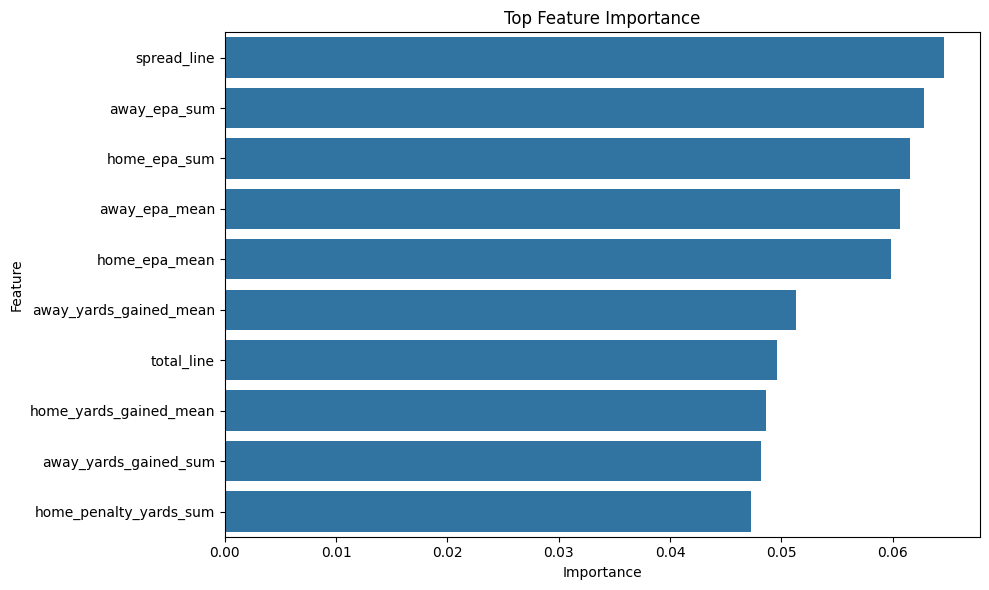

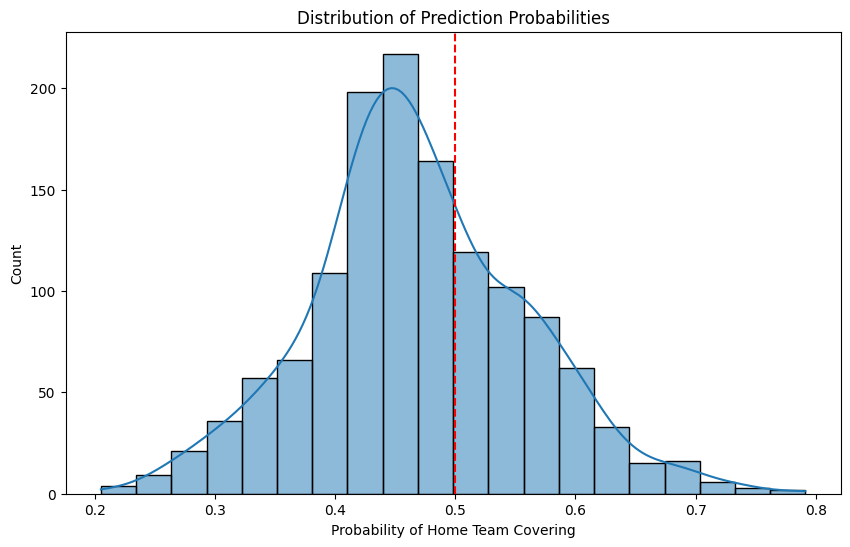

In [36]:
# --- 9. Visualization ---
print("Creating visualizations...")

# Feature importance plot
plt.figure(figsize=(10, 6))
top_features = feature_importance.head(min(10, len(feature_importance)))
sns.barplot(x='Importance', y='Feature', data=top_features)
plt.title('Top Feature Importance')
plt.tight_layout()
plt.savefig('feature_importance.png')
print("Saved feature importance plot as 'feature_importance.png'")

# Prediction probability distribution
plt.figure(figsize=(10, 6))
sns.histplot(prob_pred, bins=20, kde=True)
plt.axvline(0.5, color='red', linestyle='--')
plt.title('Distribution of Prediction Probabilities')
plt.xlabel('Probability of Home Team Covering')
plt.savefig('prediction_distribution.png')
print("Saved prediction distribution plot as 'prediction_distribution.png'")

print("\nModel development complete!")
print("\nNext steps:")
print("1. Add more sophisticated features like team trends and player data")
print("2. Experiment with different ML algorithms like XGBoost or neural networks")
print("3. Implement cross-validation for more robust performance assessment")
print("4. Fine-tune the betting strategy by considering odds movement")

#  XGBoost with Grid Search

In [43]:
# NFL Betting ML Model with nflfastpy using XGBoost and Grid Search
# This script builds a machine learning model to predict game outcomes against the spread

import pandas as pd
import numpy as np
import nfl_data_py as nfl
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Filter out warnings
warnings.filterwarnings('ignore', message='invalid value encountered in divide')

# Set the random seed for reproducibility
np.random.seed(42)

In [44]:
# --- 1. Data Collection ---
print("Collecting NFL data...")

# Get play-by-play data from the last 5 seasons
seasons = list(range(2018, 2024))
pbp_data = nfl.import_pbp_data(seasons)

# Get schedule data which includes betting information
schedule_data = nfl.import_schedules(seasons)

# Initial data quality check
print(f"Play-by-play data shape: {pbp_data.shape}")
print(f"Schedule data shape: {schedule_data.shape}")

2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
Downcasting floats.
Play-by-play data shape: (291093, 391)
Schedule data shape: (1657, 46)


In [45]:
# --- 2. Feature Engineering ---
print("Engineering features...")

# Create game-level aggregations from play-by-play data
def aggregate_game_stats(pbp_df):
    # Filter out rows with missing game_id or posteam
    filtered_df = pbp_df.dropna(subset=['game_id', 'posteam'])
    
    # Group by game_id and team to calculate team stats per game
    game_stats = filtered_df.groupby(['game_id', 'posteam']).agg({
        'epa': ['mean', 'sum'],  # Efficiency metrics
        'pass': ['sum'],         # Pass attempts
        'rush': ['sum'],         # Rush attempts
        'yards_gained': ['sum', 'mean'],  # Yardage
        'first_down': ['sum'],   # First downs
        'third_down_converted': ['sum'],  # Third down conversions
        'third_down_failed': ['sum'],     # Third down failures
        'fumble': ['sum'],       # Turnovers
        'interception': ['sum'],
        'penalty_yards': ['sum'] # Penalties
    }).reset_index()
    
    # Flatten multi-level columns
    game_stats.columns = ['_'.join(col).strip('_') for col in game_stats.columns.values]
    
    return game_stats

game_stats = aggregate_game_stats(pbp_data)

# Process schedule data to include betting information
betting_df = schedule_data[['gameday', 'game_id', 'home_team', 'away_team', 
                            'home_score', 'away_score', 'spread_line', 'total_line']]

# Check for missing values in betting columns
print("Missing values in betting data:")
print(betting_df[['spread_line', 'total_line']].isnull().sum())

# Convert spread_line to numeric, coercing errors to NaN
betting_df['spread_line'] = pd.to_numeric(betting_df['spread_line'], errors='coerce')
betting_df['total_line'] = pd.to_numeric(betting_df['total_line'], errors='coerce')

# Create target variable: did the home team cover the spread?
betting_df['home_team_margin'] = betting_df['home_score'] - betting_df['away_score']
betting_df['home_team_covered'] = (betting_df['home_team_margin'] > betting_df['spread_line']).astype(int)

# Drop rows where we can't determine if the spread was covered
betting_df = betting_df.dropna(subset=['home_team_covered', 'spread_line'])

Engineering features...
Missing values in betting data:
spread_line    0
total_line     0
dtype: int64


/var/folders/34/g4lmjsg53yn3m175jbcsg1gm0000gn/T/ipykernel_25360/1387372434.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betting_df['spread_line'] = pd.to_numeric(betting_df['spread_line'], errors='coerce')
/var/folders/34/g4lmjsg53yn3m175jbcsg1gm0000gn/T/ipykernel_25360/1387372434.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betting_df['total_line'] = pd.to_numeric(betting_df['total_line'], errors='coerce')
/var/folders/34/g4lmjsg53yn3m175jbcsg1gm0000gn/T/ipykernel_25360/1387372434.py:43: S

In [46]:
# --- 3. Merge Game Stats with Betting Data ---
print("Merging datasets...")

# Function to join team stats to the betting dataframe
def create_full_dataset(betting_df, game_stats):
    # Create separate home and away team features
    dataset = betting_df.copy()
    
    # Convert game ID format to match between datasets if needed
    game_stats['game_id'] = game_stats['game_id'].astype(str)
    dataset['game_id'] = dataset['game_id'].astype(str)
    
    # Add basic features that should be available regardless of merge success
    dataset['abs_spread'] = abs(dataset['spread_line'])
    dataset['home_favorite'] = (dataset['spread_line'] < 0).astype(int)
    
    # Try to join home team stats - in a real implementation, you'd need to handle team codes correctly
    try:
        # Basic attempt to join home team stats
        home_stats = game_stats.copy()
        home_stats = home_stats.rename(columns={col: f'home_{col}' for col in home_stats.columns if col not in ['game_id', 'posteam']})
        dataset = pd.merge(dataset, home_stats, left_on='game_id', right_on='game_id', how='left')
        
        # Same for away team stats
        away_stats = game_stats.copy()
        away_stats = away_stats.rename(columns={col: f'away_{col}' for col in away_stats.columns if col not in ['game_id', 'posteam']})
        dataset = pd.merge(dataset, away_stats, left_on='game_id', right_on='game_id', how='left')
    
    except Exception as e:
        print(f"Warning: Could not merge team stats: {e}")
        # We'll continue with just the betting features
    
    # Drop duplicate columns
    dataset = dataset.loc[:, ~dataset.columns.duplicated()]
    
    return dataset

# Create the full dataset
full_dataset = create_full_dataset(betting_df, game_stats)

Merging datasets...


In [47]:
# --- 4. Prepare ML Features ---
print("Preparing ML features...")

# Select numerical features (avoid using target-related columns as features)
exclude_cols = ['gameday', 'gameid', 'home_team', 'away_team', 'home_score', 'away_score', 
                'home_team_margin', 'home_team_covered', 'game_id', 'posteam']

# Get all numeric columns
numeric_cols = full_dataset.select_dtypes(include=[np.number]).columns.tolist()

# Filter out excluded columns
feature_cols = [col for col in numeric_cols if not any(ex in col for ex in exclude_cols)]

# Ensure we have the basic betting features
basic_features = ['spread_line', 'abs_spread', 'home_favorite', 'total_line']
for feat in basic_features:
    if feat in full_dataset.columns and feat not in feature_cols:
        feature_cols.append(feat)

# Make sure we have some features to work with
if len(feature_cols) < 3:
    print("Warning: Very few features available. Model may not perform well.")
    # Add simple features just to demonstrate the process
    full_dataset['abs_spread'] = abs(full_dataset['spread_line'])
    full_dataset['home_favorite'] = (full_dataset['spread_line'] < 0).astype(int)
    feature_cols = ['abs_spread', 'home_favorite', 'total_line']

# Print feature information
print(f"Using {len(feature_cols)} features: {feature_cols}")

X = full_dataset[feature_cols].copy()
y = full_dataset['home_team_covered']

# Check for missing values in features
print("Missing values in features:")
missing_values = X.isnull().sum()
print(missing_values[missing_values > 0])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Preparing ML features...
Using 28 features: ['spread_line', 'total_line', 'abs_spread', 'home_favorite', 'home_epa_mean', 'home_epa_sum', 'home_pass_sum', 'home_rush_sum', 'home_yards_gained_sum', 'home_yards_gained_mean', 'home_first_down_sum', 'home_third_down_converted_sum', 'home_third_down_failed_sum', 'home_fumble_sum', 'home_interception_sum', 'home_penalty_yards_sum', 'away_epa_mean', 'away_epa_sum', 'away_pass_sum', 'away_rush_sum', 'away_yards_gained_sum', 'away_yards_gained_mean', 'away_first_down_sum', 'away_third_down_converted_sum', 'away_third_down_failed_sum', 'away_fumble_sum', 'away_interception_sum', 'away_penalty_yards_sum']
Missing values in features:
Series([], dtype: int64)


In [48]:
# --- 5. Feature Preprocessing ---
print("Preprocessing features...")

# Handle missing values with imputation
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Check for any remaining NaN values after imputation
if np.isnan(X_train_imputed).any():
    print("Warning: NaN values still present after imputation")
    # Replace any remaining NaNs with 0
    X_train_imputed = np.nan_to_num(X_train_imputed)
    X_test_imputed = np.nan_to_num(X_test_imputed)

# Use RobustScaler which is less affected by outliers
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

Preprocessing features...


In [69]:
# --- 6. Build and Train the XGBoost Model with Grid Search ---
import xgboost as xgb
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm

print("Setting up XGBoost with Grid Search...")

# Define the XGBoost classifier
xgb_model = xgb.XGBClassifier(
    eval_metric='logloss',
    random_state=42
)

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, 9, 11],
    'learning_rate': [0.001, 0.01, 0.05],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [1, 3, 5],
    'reg_alpha': [0, 0.1, 0.5, 1.0],
    'reg_lambda': [0.1, 0.5, 1.0]
}

# Generate all combinations of hyperparameters
param_combinations = list(itertools.product(
    param_grid['n_estimators'],
    param_grid['max_depth'],
    param_grid['learning_rate'],
    param_grid['subsample'],
    param_grid['colsample_bytree'],
    param_grid['gamma'],
    param_grid['min_child_weight'],
    param_grid['reg_alpha'],
    param_grid['reg_lambda']
))

print(f"Total parameter combinations: {len(param_combinations)}")
best_score = 0
best_params = None
best_model = None

# Progress bar for tracking
with tqdm(total=len(param_combinations), desc="Grid Search Progress") as pbar:
    for params in param_combinations:
        # Extract parameters
        param_dict = {
            'n_estimators': params[0],
            'max_depth': params[1],
            'learning_rate': params[2],
            'subsample': params[3],
            'colsample_bytree': params[4],
            'gamma': params[5],
            'min_child_weight': params[6],
            'reg_alpha': params[7],
            'reg_lambda': params[8]
        }

        # Train model
        model = xgb.XGBClassifier(eval_metric='logloss', random_state=42, **param_dict)
        model.fit(X_train_scaled, y_train)

        # Evaluate performance
        y_val_pred = model.predict(X_test_scaled)
        score = accuracy_score(y_test, y_val_pred)

        # Check for best model
        if score > best_score:
            best_score = score
            best_params = param_dict
            best_model = model

        # Update progress bar
        pbar.update(1)

print("\nBest parameters found:")
for param, value in best_params.items():
    print(f"{param}: {value}")

# Make predictions with the best model
y_pred = best_model.predict(X_test_scaled)
prob_pred = best_model.predict_proba(X_test_scaled)[:, 1]

Setting up XGBoost with Grid Search...
Total parameter combinations: 58320


Grid Search Progress: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 58320/58320 [10:22:46<00:00,  1.56it/s]


Best parameters found:
n_estimators: 300
max_depth: 11
learning_rate: 0.05
subsample: 1.0
colsample_bytree: 0.8
gamma: 0.1
min_child_weight: 1
reg_alpha: 0
reg_lambda: 0.1


In [70]:
# --- 7. Evaluate the Model ---
print("\nEvaluating model performance...")

accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature importance analysis
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance.head(10))

# Cross-validation results
print("\nCross-validation results:")
print(f"Mean CV Score: {grid_search.best_score_:.4f}")
print(f"Standard Deviation: {np.std(grid_search.cv_results_['split0_test_score']):.4f}")


Evaluating model performance...
Model Accuracy: 0.8982

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.92      0.91       701
           1       0.91      0.87      0.89       625

    accuracy                           0.90      1326
   macro avg       0.90      0.90      0.90      1326
weighted avg       0.90      0.90      0.90      1326


Feature Importance:
                       Feature  Importance
17                away_epa_sum    0.048140
0                  spread_line    0.045295
5                 home_epa_sum    0.043439
16               away_epa_mean    0.041128
4                home_epa_mean    0.039457
21      away_yards_gained_mean    0.038217
19               away_rush_sum    0.037880
8        home_yards_gained_sum    0.037166
20       away_yards_gained_sum    0.037096
24  away_third_down_failed_sum    0.036341

Cross-validation results:


AttributeError: 'GridSearchCV' object has no attribute 'best_score_'

In [71]:
# --- 8. Betting Strategy Simulation ---
print("\nSimulating betting strategy...")

# Create a dataframe with test results
test_results = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred,
    'Probability': prob_pred
})

# Simulate betting strategies with different confidence thresholds
thresholds = [0.5, 0.55, 0.6, 0.65, 0.7, 0.8, 0.9]
results = []

for threshold in thresholds:
    # Bet when model confidence > threshold (for home team) or < (1-threshold) for away team
    test_results['Bet'] = (test_results['Probability'] > threshold) | (test_results['Probability'] < (1-threshold))
    test_results['Win'] = test_results['Predicted'] == test_results['Actual']
    
    # Calculate returns assuming -110 odds (bet 110 to win 100)
    test_results['Return'] = np.where(
        test_results['Bet'] & test_results['Win'], 100, 
        np.where(test_results['Bet'] & ~test_results['Win'], -110, 0)
    )
    
    total_bets = test_results['Bet'].sum()
    if total_bets > 0:
        winning_bets = test_results[test_results['Bet']]['Win'].sum()
        win_rate = winning_bets / total_bets
        profit = test_results['Return'].sum()
        roi = profit / (total_bets * 110)
        
        results.append({
            'Threshold': threshold,
            'Total Bets': total_bets,
            'Win Rate': win_rate,
            'Profit': profit,
            'ROI': roi
        })

# Display results for different thresholds
results_df = pd.DataFrame(results)
print("\nBetting Strategy Results for Different Confidence Thresholds:")
print(results_df)

# Find optimal threshold
if results:
    best_threshold = results_df.loc[results_df['ROI'].idxmax()]
    print(f"\nOptimal threshold: {best_threshold['Threshold']}")
    print(f"With this threshold, you would place {best_threshold['Total Bets']} bets")
    print(f"Win rate: {best_threshold['Win Rate']:.4f}")
    print(f"Profit: ${best_threshold['Profit']:.2f}")
    print(f"ROI: {best_threshold['ROI']:.4f}")


Simulating betting strategy...

Betting Strategy Results for Different Confidence Thresholds:
   Threshold  Total Bets  Win Rate  Profit       ROI
0       0.50        1326  0.898190  104250  0.714726
1       0.55        1253  0.913807  102620  0.744540
2       0.60        1162  0.929432   98980  0.774370
3       0.65        1082  0.942699   95180  0.799698
4       0.70         974  0.957906   88790  0.828729
5       0.80         726  0.976584   69030  0.864388
6       0.90         321  0.990654   31470  0.891249

Optimal threshold: 0.9
With this threshold, you would place 321.0 bets
Win rate: 0.9907
Profit: $31470.00
ROI: 0.8912



Creating visualizations...
Saved feature importance plot as 'xgboost_feature_importance.png'


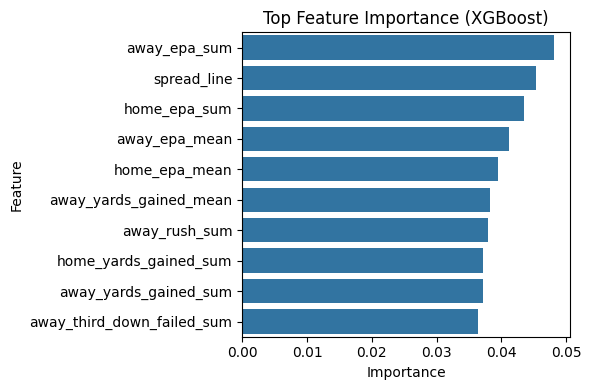

In [72]:
# --- 9. Visualization ---
print("\nCreating visualizations...")

# Feature importance plot
plt.figure(figsize=(6, 4))
top_features = feature_importance.head(min(10, len(feature_importance)))
sns.barplot(x='Importance', y='Feature', data=top_features)
plt.title('Top Feature Importance (XGBoost)')
plt.tight_layout()
plt.savefig('xgboost_feature_importance.png')
print("Saved feature importance plot as 'xgboost_feature_importance.png'")

Saved prediction distribution plot as 'xgboost_prediction_distribution.png'


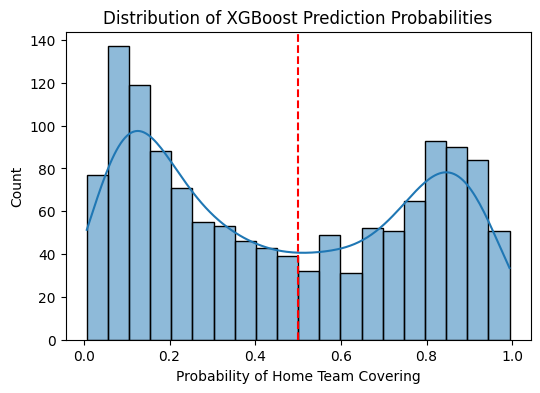

In [73]:
# Prediction probability distribution
plt.figure(figsize=(6, 4))
sns.histplot(prob_pred, bins=20, kde=True)
plt.axvline(0.5, color='red', linestyle='--')
plt.title('Distribution of XGBoost Prediction Probabilities')
plt.xlabel('Probability of Home Team Covering')
plt.savefig('xgboost_prediction_distribution.png')
print("Saved prediction distribution plot as 'xgboost_prediction_distribution.png'")

Saved threshold analysis plot as 'threshold_vs_roi.png'

XGBoost model development complete!

Next steps:
1. Collect more data features like team trends, weather, and player injuries
2. Implement feature engineering to create more predictive variables
3. Consider backtesting over multiple seasons
4. Explore different betting strategies beyond simple thresholding


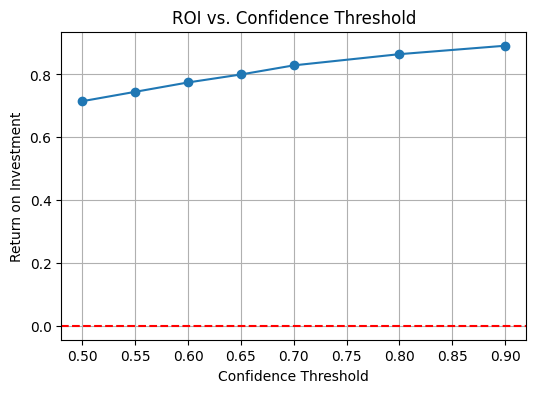

In [74]:
# Plot ROI vs Threshold
if results:
    plt.figure(figsize=(6, 4))
    plt.plot(results_df['Threshold'], results_df['ROI'], marker='o')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('ROI vs. Confidence Threshold')
    plt.xlabel('Confidence Threshold')
    plt.ylabel('Return on Investment')
    plt.grid(True)
    plt.savefig('threshold_vs_roi.png')
    print("Saved threshold analysis plot as 'threshold_vs_roi.png'")

print("\nXGBoost model development complete!")
print("\nNext steps:")
print("1. Collect more data features like team trends, weather, and player injuries")
print("2. Implement feature engineering to create more predictive variables")
print("3. Consider backtesting over multiple seasons")
print("4. Explore different betting strategies beyond simple thresholding")